# An Introduction to the Black-Litterman in Python

## Introduction
### Background and Theory

The Black-Litterman asset allocation model \cite{black1992global}, \cite{he1999intuition} provides a methodical way of combining an investors subjective views of the future performance of a risky investment asset with the views implied by the market equilibrium. The method has seen wide acceptance amongst practitioners as well as academics in spite of the fact that it originated as an internal Goldman Sachs working paper, rather than as a piece of research from academia.

The Black Litterman procedure can be viewed as a bayesian shrinkage method, that shrinks the expected returns constructed from an investor's views on asset returns towards asset returns implied by the market equilibrium. The procedure computes a set of expected returns that uses the market equilibrium implied  as a prior. This is then combined with returns implied by subjective investor views to produce a set of posterior expected returns $\mu^{BL}$ and covariances $\Sigma^{BL}$.

Besides the obvious attraction of being able to incorporate subjective investor views, the Black-Litterman procedure has a second feature that makes it extremely attractive to portfolio optimization. It is well known that the Markowitz optimization procedure is highly sensitive to estimation errors in Expected Returns and Covariances, and this _error maximizing_ nature of the Markowitz procedure causes unstable portfolios with extreme weights that diverge rapidly from the market equilibrium portfolio even with minor changes to the inputs (e.g. \cite{chopra1993effect}, \cite{michaud1989markowitz}). However, the posterior parameters $\mu^{BL}, \Sigma^{BL}$ computed by the Black Litterman procedure are derived in part from the market portfolio, and therefore are much more pragmatic inputs for purposes of portfolio optimization. Specifically, when $\mu^{BL}, \Sigma^{BL}$ as used as as inputs to a Markowitz Optimizer, they produce optimized weights that diverge from the market portfolio in limited ways, and only to the extent of the confidence that the investor expresses in the views. Consequently the optimized portfolios are more stable portfolios than with pure Markowitz optimization with sample estimates. In the extreme, with appropriately set parameters, the Markowitz portfolio computed from the Black-Litterman parameters when there are no subjective investor views exactly coincides and is able to recover the market equilibrium portfolio.

### The Black Litterman Formulas

Assume that we have $N$ assets, and $K$ views. There are two sets of inputs to the procedure. The first set of inputs relate to market parameters and these are:

\begin{array}{ll}
w & \mbox{A Column Vector ($N \times 1$) of Equilibrium Market Weights of the Assets} \\
\Sigma & \mbox{A Covariance Matrix ($N \times N$) of the Assets} \\
R_f & \mbox{The Risk Free Rate} \\
\delta & \mbox{The investor's Risk Aversion parameter}  \\
\tau & \mbox{A scalar indicating the uncertainty of the prior (details below)}
\end{array}


Some of these parameters can be inferred from other parameters if they are not explicitly specified. For instance, the risk aversion parameter can be set arbitrarily. For instance, some authors use $\delta = 2.5$ while others use the value of $\delta = 2.14$ in order to be consistent with the value calculated in \cite{dimson2008triumph}.

\cite{beach2007application} suggest using $2.65$. Another common approach is to set $\delta$ to the Market Price of Risk (i.e. a measure of the risk aversion of the Representative Investor, which is computed as $\delta = \mu_M/\sigma^2_M$ where $\mu_M$ and $\sigma^2_M$ are estimates of the mean and variance of the returns of the market portfolio. Frequently, a broad market index such as the S\&P500 is taken as a proxy for the market in order to compute the market price of risk from $\mu_M$ and $\sigma^2_M$.

The treatment of $\tau$ is the source of some confusion. As we will explain in the following section, some implementors have done away with $\tau$ by setting it to $1$ or to calibrate the model to $tau$. In the original model, Black and Litterman suggest using a small number. A common technique is to set $\tau = 1/T$ where $T$ is the number of periods of data used. Thus, for $T=5$ you would use $1/(5 \times 12)$ which yields a value of approximately $\tau=.02$.

The second set of inputs that the procedure needs is a representation of the investors views. These are specified via:

\begin{array}{ll}
Q & \mbox{An $K \times 1$ ``Qualitative Views'' or simply, Views matrix} \\
P & \mbox{A $K \times N$ ``Projection'' or ``Pick'' matrix, linking each view to the assets} \\
\Omega & \mbox{A Covariance matrix representing the uncertainty of views}
\end{array}


Views are represented in $Q$ and $P$ as follows:

If the $k$-th view is an absolute view, it is represented by setting $Q_k$ to the expected return of asset $k$ and setting $P_{ki}$ to 1 and all other elements of row $k$ in $P$ to zero.

If the $k$-th view is an relative view, between assets $i$ and $j$ it is represented by setting $Q_k$ to the expected difference of returns between assets $i$ and $j$, and setting $P_{ki}$ to $-1$ for the underperforming asset, $P_{kj}$ to $+1$ and all other elements of row $k$ in $P$ to zero. $\Omega$ is either set to the specified uncertainty or is inferred from the user or from the data.

The uncertainty of the views $\Omega$ is either set by the user, or inferred (e.g. via statements of confidence, from market data, from the variance of residuals from a prediction model used to generate the views etc, we shall see examples in sections below). In particular, \cite{he1999intuition} suggest setting it to be the diagonal matrix obtained from the diagonal elements of $P \tau \Sigma P^T$, which is what we shall do for some of our initial tests. In my implementation the code accepts a matrix, but uses this assumption as the default if the user does not specify a matrix to use as $\Omega$.

#### The Master Formula

The first step of the procedure is a _reverse-optimization_ step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$\pi = \delta\Sigma w$$

Next, the posterior returns and covariances are obtained from the _Black-Litterman Master Formula_ which is the following set of equations:

\begin{equation}
\label{eq:blMuOrig}
\mu^{BL} = [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}[(\tau\Sigma)^{-1} \pi + P \Omega^{-1} Q]
\end{equation}

\begin{equation}
\label{eq:blSigmaOrig}
\Sigma^{BL} = \Sigma + [(\tau\Sigma)^{-1} + P \Omega^{-1} P]^{-1}
\end{equation}

#### Inverting $\Omega$

While the master formulas identified in Equation \ref{eq:blMuOrig} and Equation \ref{eq:blSigmaOrig} are frequently easy to implement, they do involve the term $\Omega^{-1}$. Unfortuantely, $\Omega$ is sometimes non-invertible, which poses difficulties to implement the equations as-is. Fortunately the equations are easily transformed to a form that does not require this troublesome inversion. Therefore, frequently, implementations use the following equivalent versions of these equations which are sometimes computationally more stable, since they do not involve inverting $\Omega$. Derivations of these alternate forms are provided in the appendices of \cite{walters2011black}:

\begin{equation}
\label{eq:blMu}
\mu^{BL} = \pi + \tau \Sigma P^T[(P \tau \Sigma P^T) + \Omega]^{-1}[Q - P \pi]
\end{equation}

\begin{equation}
\label{eq:blSigma}
\Sigma^{BL} = \Sigma + \tau \Sigma - \tau\Sigma P^T(P \tau \Sigma P^T + \Omega)^{-1} P \tau \Sigma
\end{equation}


### Flavors of Black-Litterman

The original method described above has also seen a number of modifications and extensions (e.g. see \cite{walters2011black} for an extensive and detailed summary) to the point where there is some confusion about exactly what comprises the true _Black-Litterman_ model.

I shall use a nomenclature that is consistent with \cite{walters2011black}. Walters classifies implementations in two broad categories. The first category was implemented by \cite{black1992global} and \cite{he1999intuition}, and Walters refers to these as the _Reference Model_. The second category consists of well known implementations described in \cite{satchell2000demystification} and a series of papers by Meucci (e.g. \cite{meucci2005beyond}, \cite{meucci2009enhancing}, \cite{meucci2012fully}). In these models, the $\tau$ parameter is eliminated, either by setting it to 1 or by incorporating it into the $\Omega$ matrix.

For the rest of this document, I shall be restricting myself to the _Reference Model_ as originally described in \cite{black1992global} and \cite{he1999intuition}, and I shall not be implementing the extensions of Meucci and others.

### Implementation Overview

The rest of this notebook proceeds as follows. In the following section, I shall implement the Black Litterman procedure in Python and annotate the code as I proceed, to illustrate each step. I then use the code to exactly reproduce the results in \cite{he1999intuition}.
 
Having established that the code accurately implements the Black Litterman procedure, I shall get down apply the procedure to the Fama French 6-portfolio allocation problem. Along the way, my tests will impose absolute views as well as relative views, and test the impact of the procedure on portfolios using a range of Seven different prediction strategies to obtain views. I also backtest these strategies over time and examine various portfolio metrics, while comparing the Black Litterman derived (BL) expected returns being supplied to an optimizer with weights obtained from Naive Mean-Variance optimization using expected returns and covariance matrixes directly from the prediction strategy. Finally, I conclude the section by examining the impact of these portfolios on transaction costs. 
 
## Annotated Implementation of Black-Litterman
### The Code

The Black Litterman procedure is implemented in Python in the function `bl`. Before we implement the body of `bl`, let's build a few helper functions that will hopefully make the code a bit easier to understand and deal with.

numpy treats a column vector differently from a 1 dimensional array. In order to consistently use column vectors, the following helper function takes either a numpy array or a numpy one-column matrix (i.e. a column vector) and returns the data as a column vector. Let's call this function `as_colvec`


In [1]:
import numpy as np
import pandas as pd

def as_colvec(x):
    if (x.ndim == 2):
        return x
    else:
        return np.expand_dims(x, axis=1)


In [2]:
np.arange(4)

array([0, 1, 2, 3])

In [3]:
as_colvec(np.arange(4))

array([[0],
       [1],
       [2],
       [3]])

Recall that the first step in the Black Litterman procedure was to reverse engineer the implied returns vector $\pi$ from a set of portfolio weights $w$. 

$$\pi = \delta\Sigma w$$

This is performed by the following code:

In [17]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir


As we noted previously, \cite{he1999intuition} suggest that if the investor does not have a specific way to explicitly quantify the uncertaintly associated with the view in the $\Omega$ matrix, one could make the simplifying assumption that $\Omega$ is proportional to the variance of the prior.

Specifically, they suggest that:

$$\Omega = diag(P (\tau \Sigma) P^T) $$

This is implemented in Python as:

In [35]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)


We use this function to compute the posterior expected returns as follows:

In [33]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
    #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)


### A Simple Example: Absolute Views

We start with a simple 2-Asset example. Let's start with an example from _Statistical Models and Methods for Financial Markets (Springer Texts in Statistics) 2008th Edition, Tze Lai and Haipeng Xing_.

Consider the portfolio consisting of just two stocks: Intel (INTC) and Pfizer (PFE).

From Table 3.1 on page 72 of the book, we obtain the covariance matrix (multipled by $10^4$)

\begin{array}{lcc}
INTC & 46.0 & 1.06 \\
PFE   & 1.06 & 5.33
\end{array}

Assume that Intel has a market capitalization of approximately USD 80B and that of Pfizer is approximately USD 100B (this is not quite accurate, but works just fine as an example!).
Thus, if you held a market-cap weighted portfolio you would hold INTC and PFE with the following weights: $W_{INTC} = 80/180 = 44\%, W_{PFE} = 100/180 = 56\%$. These appear to be reasonable weights without an extreme allocation to either stock, even though Pfizer is slightly overweighted.

We can compute the equilibrium implied returns $\pi$ as follows:


In [7]:
tickers = ['INTC', 'PFE']
s = pd.DataFrame([[46.0, 1.06], [1.06, 5.33]], index=tickers, columns=tickers) *  10E-4
pi = implied_returns(delta=2.5, sigma=s, w=pd.Series([.44, .56], index=tickers))
pi

INTC    0.052084
PFE     0.008628
Name: Implied Returns, dtype: float64

Thus the equilibrium implied returns for INTC are a bit more than 5\% and a bit less than 1\% for PFE.

Assume that the investor thinks that Intel will return 2\% and that Pfizer is poised to rebounce, and will return 4\% . We can now examine the optimal weights according to the Markowitz procedure.
What would happen if we used these expected returns to compute the Optimal Max Sharpe Ratio portfolio?

The Max Sharpe Ratio (MSR) Portfolio weights are easily computed in explicit form if there are no constraints on the weights.
The weights are given by the expression (e.g. See  \cite{campbell1996econometrics} page 188 Equation 5.2.28):

$$ W_{MSR} = \frac{\Sigma^{-1}\mu_e}{\bf{1}^T \Sigma^{-1}\mu_e} $$

where $\mu_e$ is the vector of expected excess returns and $\Sigma$ is the variance-covariance matrix.

This is implemented as follows:



In [38]:
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w


Recall that the investor expects that Intel will return 2\% and Pfizer will return 4\% . We can now examine the optimal weights obtained by naively implementing the Markowitz procedure with these expected returns.

In [9]:
mu_exp = pd.Series([.02, .04],index=tickers) # INTC and PFE
np.round(w_msr(s, mu_exp)*100, 2)


INTC     3.41
PFE     96.59
dtype: float64

Consistent with the poor reputation of naive Markowitz optimization, the Markwitz procedure places an unrealistic weight of more than 96\% in Pfizer and less than 4\% in Intel. This is completely impractical and no reasonable investor would make such dramatic bets.

In contrast, let us now find the weights that the Black Litterman procedure would place. We allow $\Omega$ to be computed automatically, and are willing to use all the other defaults. We find the Black Litterman weights as follows:

In [10]:
# Absolute view 1: INTC will return 2%
# Absolute view 2: PFE will return 4%
q = pd.Series({'INTC': 0.02, 'PFE': 0.04})

# The Pick Matrix
# For View 2, it is for PFE
p = pd.DataFrame([
# For View 1, this is for INTC
    {'INTC': 1, 'PFE': 0},
# For View 2, it is for PFE
    {'INTC': 0, 'PFE': 1}
    ])

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=pd.Series({'INTC':.44, 'PFE':.56}), sigma_prior=s, p=p, q=q)
# Black Litterman Implied Mu
bl_mu


INTC    0.037622
PFE     0.024111
dtype: float64

The posterior returns returned by the procedure are clearly weighted between that of the equilibrium implied expected returns (in the range of 5\% and 1\%) and that of the investor (2\% and 4\%). The question is are these weights likely to yield more realistic portfolios? To answer that question we supply the Black Litterman expected returns and covariance matrix to the optimizer:

In [11]:
# Use the Black Litterman expected returns to get the Optimal Markowitz weights
w_msr(bl_sigma, bl_mu)

INTC    0.140692
PFE     0.859308
dtype: float64

We see that we get much more reasonable weights than we did with naive optimization. These weights are also much closer to the 45-55 mix in the cap weighted portfolio.
On the other hand, they respect the investor's view that expects Pfizer to rebound, and places a higher weight on Pfizer relative to the cap weighted portfolio.

### A Simple Example: Relative Views

In this example, we examine relative views. We stick with our simple 2-stock example. Recall that the Cap-Weighted implied expected returns are:


In [12]:
# Expected returns inferred from the cap-weights
pi


INTC    0.052084
PFE     0.008628
Name: Implied Returns, dtype: float64

Recall also that the cap-weighted portfolio is approximately a 45-55 mix of Intel and Pfizer.

Assume instead that the investor feels that the Intel will outperform Pfizer by only 2\%. This view is implemented as follows:

In [13]:
q = pd.Series([
# Relative View 1: INTC will outperform PFE by 2%
  0.02
    ]
)
# The Pick Matrix
p = pd.DataFrame([
  # For View 1, this is for INTC outperforming PFE
  {'INTC': +1, 'PFE': -1}
])

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_prior=pd.Series({'INTC': .44, 'PFE': .56}), sigma_prior=s, p=p, q=q)
# Black Litterman Implied Mu
bl_mu


INTC    0.041374
PFE     0.009646
dtype: float64

Once again we see that the Black Litterman expected returns are a blend between the cap-weight implied weights and the investor view. The outperformance of Intel in the implied returns is:

In [14]:
pi[0]-pi[1]

0.043456

In contrast, the investor felt it only would be 2\%. The expected returns returned by the Black Litterman procedure show a spread that is a blend between the cap-weight implied returns and that of the investor:

In [15]:
bl_mu[0]-bl_mu[1]

0.031728

And, the weights in the Optimized portfolio when we use these expected returns are:


In [16]:
# Use the Black Litterman expected returns and covariance matrix
w_msr(bl_sigma, bl_mu)

INTC    0.347223
PFE     0.652777
dtype: float64

These seem like reasonable weights, and demonstrates the power of using the Black Litterman procedure. In contrast, consider the weights we would get if we implemented the same view without Black Litterman. We set the returns of Intel and Pfizer to be 3\% and 1\% respectively.

In [17]:
w_msr(s, [.03, .01])

INTC    0.258528
PFE     0.741472
dtype: float64

The weights are significantly more dramatic than one might be willing to implement, and are likely unwarranted given the relatively weak view. In fact, if the same view were implemented as Intel and Pfizer returning 2\% and 0\%, the results are even more extreme:

In [18]:
w_msr(s, [.02, .0])

INTC    1.248244
PFE    -0.248244
dtype: float64

In this case, the Markowitz recommends shorting Pfizer to the extent of nearly 25\% of the portfolio and leveraging Intel to 125\%. Clearly this is not a plausible allocation based on the simple view expressed above.

## Reproducing the He-Litterman (1999) Results

We now reproduce the results in the He-Litterman paper that first detailed the steps in the procedure. We obtained the data by typing it in from the He-Litterman tables, and used it to test the implementation.

The He-Litterman example involves an international allocation between 7 countries. The data is as follows:

In [19]:
# The 7 countries ...
countries  = ['AU', 'CA', 'FR', 'DE', 'JP', 'UK', 'US'] 
# Table 1 of the He-Litterman paper
# Correlation Matrix
rho = pd.DataFrame([
    [1.000,0.488,0.478,0.515,0.439,0.512,0.491],
    [0.488,1.000,0.664,0.655,0.310,0.608,0.779],
    [0.478,0.664,1.000,0.861,0.355,0.783,0.668],
    [0.515,0.655,0.861,1.000,0.354,0.777,0.653],
    [0.439,0.310,0.355,0.354,1.000,0.405,0.306],
    [0.512,0.608,0.783,0.777,0.405,1.000,0.652],
    [0.491,0.779,0.668,0.653,0.306,0.652,1.000]
], index=countries, columns=countries)

# Table 2 of the He-Litterman paper: volatilities
vols = pd.DataFrame([0.160,0.203,0.248,0.271,0.210,0.200,0.187],index=countries, columns=["vol"]) 
# Table 2 of the He-Litterman paper: cap-weights
w_eq = pd.DataFrame([0.016,0.022,0.052,0.055,0.116,0.124,0.615], index=countries, columns=["CapWeight"])
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho
# Compute Pi and compare:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=w_eq)
(pi*100).round(1)

AU    3.9
CA    6.9
FR    8.4
DE    9.0
JP    4.3
UK    6.8
US    7.6
Name: Implied Returns, dtype: float64

The values of $\pi$ computed by the Python code exactly matches column 3 of Table 2

### View 1: Germany vs Rest of Europe

Next, we impose the view that German equities will outperform the rest of European equities by 5\%.

The other European equities are France and the UK. We split the outperformance proportional to the Market Caps of France and the UK.


In [20]:
# Germany will outperform other European Equities (i.e. FR and UK) by 5%
q = pd.Series([.05]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(countries), index=countries).T
# find the relative market caps of FR and UK to split the
# relative outperformance of DE ...
w_fr =  w_eq.loc["FR"]/(w_eq.loc["FR"]+w_eq.loc["UK"])
w_uk =  w_eq.loc["UK"]/(w_eq.loc["FR"]+w_eq.loc["UK"])
p.iloc[0]['DE'] = 1.
p.iloc[0]['FR'] = -w_fr
p.iloc[0]['UK'] = -w_uk
(p*100).round(1)


,AU,CA,FR,DE,JP,UK,US
0,0.0,0.0,-29.5,100.0,0.0,-70.5,0.0


 The results of implementing this view appear in the He-Litterman paper in Table 4. This exactly reproduces column 1 of Table 4. Next, we examine the values of $\mu^{BL}$:


In [21]:
delta = 2.5
tau = 0.05 # from Footnote 8
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(1)


AU     4.3
CA     7.6
FR     9.3
DE    11.0
JP     4.5
UK     7.0
US     8.1
dtype: float64

The  Black Litterman expected returns computed by the code exactly reproduces column 2 of Table 4.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)


In [66]:
def w_star(delta, sigma, mu):
    return (inverse(sigma).dot(mu))/delta

wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)


Hlth     321.9
Fin      166.8
Whlsl     44.8
Rtail    241.9
Food     118.2
dtype: float64

The computed $w^*$ exactly replicates column 3 ($w^*$) of Table 4. Finally, they compute $w^* - \frac{w_{eq}}{1+\tau}$ which is the difference in weights between the optimal portfolio and the equilibrium portfolio (they use unscaled weights) in column 4. We replicate that column as follows:

In [23]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100


AU     0.0
CA    -0.0
FR    -8.9
DE    30.2
JP     0.0
UK   -21.3
US     0.0
dtype: float64

which exactly matches Column 4 of Table 4. This completes our reproduction of the first view in He-Litterman (1999).

Note that this demonstrates the power of the approach. The weights for assets that do not involve the view remain unchanged. The two underperforming countries (according to the view) are underweighted, while the overperforming country is overweighted, but not to the extreme extent that a naive portfolio optimizer would have produced.

### View 2: Canada vs US

For their second case, He and Litterman implement the additional view that Canadian Equities will outperform US Equities by 3\%. The results are in (their) Table 5, which we shall now reproduce.

In [24]:
view2 = pd.Series([.03], index=[1])
q = q.append(view2)
pick2 = pd.DataFrame([0.]*len(countries), index=countries, columns=[1]).T
p = p.append(pick2)
p.iloc[1]['CA']=+1
p.iloc[1]['US']=-1
np.round(p.T, 3)*100

,0,1
AU,0.0,0.0
CA,0.0,100.0
FR,-29.5,0.0
DE,100.0,0.0
JP,0.0,0.0
UK,-70.5,0.0
US,0.0,-100.0


This matches columns 1 and 2 of Table 5. We now compute the Black Litterman weights as
before:

In [25]:
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
np.round(bl_mu*100, 1)

AU     4.4
CA     8.7
FR     9.5
DE    11.2
JP     4.6
UK     7.0
US     7.5
dtype: float64

The Black Litterman expected returns computed by the Python code exactly reproduces column 3 of
Table 5.
He-Litterman compute the optimal portfolio w ∗ as follows (this is Equation (13) on page 6 of
their paper)

In [26]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

AU     1.5
CA    41.9
FR    -3.4
DE    33.6
JP    11.0
UK    -8.2
US    18.8
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 5. Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 5. We replicate that column as follows:

In [27]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU     0.0
CA    39.8
FR    -8.4
DE    28.4
JP    -0.0
UK   -20.0
US   -39.8
dtype: float64

Which exactly reproduces the last column of Table 5 of their paper.

Once again, we see the power of the approach. The weights for assets that do not involve the view (AU, JP) remain unchanged. The two underperforming countries (FR, UK, US, according to the view) are underweighted, while the overperforming countries (CA, DE) are overweighted, but not to the extreme extent that a naive portfolio optimizer would have produced.


### View 3: More Bullish Canada vs US

For their third case, He and Litterman alter the second view that Canadian Equities will outperform US Equities by increasing the expected out-performance from the previously stated 3\% to 4\%. The results are in Table 6 of their paper, which we shall now reproduce.


In [28]:
q[1] = .04
q

0    0.05
1    0.04
dtype: float64

Note that P remains unchanged since we have only altered Q, not P

In [29]:
np.round(p.T*100, 1)

,0,1
AU,0.0,0.0
CA,0.0,100.0
FR,-29.5,0.0
DE,100.0,0.0
JP,0.0,0.0
UK,-70.5,0.0
US,0.0,-100.0


This matches columns 1 and 2 of Table 6. We now compute the Black Litterman weights as before:

In [30]:
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
np.round(bl_mu, 3)*100

AU     4.4
CA     9.1
FR     9.5
DE    11.3
JP     4.6
UK     7.0
US     7.3
dtype: float64

The  Black Litterman expected returns computed by my code exactly reproduces column 3 of Table 6.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)


In [31]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

AU     1.5
CA    53.3
FR    -3.3
DE    33.1
JP    11.0
UK    -7.8
US     7.3
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 7. Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 6. We replicate that column as follows:

In [32]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU     0.0
CA    51.3
FR    -8.2
DE    27.8
JP    -0.0
UK   -19.6
US   -51.3
dtype: float64

Which exactly reproduces the last column of Table 6 of their paper. Again, we see how the weights increase allocations consistent with the view, but keep allocations from getting extreme.

### View 4: Increasing View Uncertainty

As a final step, He and Litterman demonstrate the effect of $\Omega$. They increase the uncertainty associated with the first of the two views (i.e. the one that Germany will outperform the rest of Europe). First we compute the default value of $\Omega$ and then increase the uncertainty associated with the first view alone.

In [33]:
# This is the default "Proportional to Prior" assumption
omega = proportional_prior(sigma_prior, tau, p)
# Now, double the uncertainty associated with View 1
omega.iloc[0,0] = 2*omega.iloc[0,0]
np.round(p.T*100, 1)

,0,1
AU,0.0,0.0
CA,0.0,100.0
FR,-29.5,0.0
DE,100.0,0.0
JP,0.0,0.0
UK,-70.5,0.0
US,0.0,-100.0


This matches columns 1 and 2 of Table 7 (which is if course, unchanged, since we have only altered $\Omega$, not Q or P). We now compute the Black Litterman weights as before, but supplying the value of $\Omega$ we just adjusted:

In [34]:
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau, omega=omega)
np.round(bl_mu, 3)*100

AU     4.3
CA     8.9
FR     9.3
DE    10.6
JP     4.6
UK     6.9
US     7.2
dtype: float64

The  Black Litterman expected returns computed by the code exactly reproduces column 3 of Table 7.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)

In [35]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

AU     1.5
CA    53.9
FR    -0.5
DE    23.6
JP    11.0
UK    -1.1
US     6.8
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 7. Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 6. We replicate that column as follows:


In [36]:
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU    -0.0
CA    51.8
FR    -5.4
DE    18.4
JP     0.0
UK   -13.0
US   -51.8
dtype: float64

Which exactly reproduces the last column of Table 7 of their paper. Again, we see how the weights increase allocations consistent with the view, but keep allocations from getting extreme.

That concludes our reproduction of the paper. Note that He and Litterman also produce an extra table (Table 8) which demonstrates the value of adding a third view. However, the third view is identical to the values implied by the equilibrium and as a result, they produce exactly the same results as Table 7. I do not bother reproduce it here since the results are exactly the same as Table 7.

## Try it on Industry Data ...

Now that you've reproduced the results, you should be able to run the code on the Fama-French Industry Portfolios ...

Start out by loading the data as follows, and then play around!

In [37]:
import edhec_risk_kit_206 as erk

ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["2014":]

**Load the 49 industries Value weighted returns and cap weights, and use the period 2013-2018 both included. For the period, use the starting cap weights of the period. Limit yourself to the following 5 industry sectors: 'Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food'.**

In [12]:
import edhec_risk_kit_206 as erk
import matplotlib
import pandas as pd
import numpy as np

ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2013":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["2013":]

**Industry sector has the highest capweight**

In [22]:
fiveind_rets = ind49_rets[['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']]
fiveind_mcap = ind49_mcap[['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']]
cap_w = fiveind_mcap.sum()
cap_w

Hlth     0.396624
Fin      1.751218
Whlsl    0.937026
Rtail    5.057213
Food     1.241093
dtype: float64

**which industry sector has the highest implied return?**

In [52]:
# The 7 countries ...
countries  = ['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']
# Table 1 of the He-Litterman paper
# Correlation Matrix
rho = fiveind_rets.corr()

# Table 2 of the He-Litterman paper: volatilities
vols = erk.annualize_vol(fiveind_rets, 1) 
# Table 2 of the He-Litterman paper: cap-weights
w_eq = cap_w
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho
# Compute Pi and compare:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=w_eq)
(pi*100).round(1)

Hlth     12.0
Fin      13.9
Whlsl    15.8
Rtail    17.5
Food     12.2
Name: Implied Returns, dtype: float64

In [47]:
inds  = ['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']
rho = fiveind_rets.corr()
# Table 2 of the He-Litterman paper: volatilities
vols = pd.DataFrame(erk.annualize_vol(fiveind_rets, 1),index=inds, columns=["vol"]) 
# Table 2 of the He-Litterman paper: cap-weights
w_eq = pd.DataFrame(cap_w, index=inds, columns=["CapWeight"])
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho
# Compute Pi and compare:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=w_eq)
(pi*100).round(1)

Hlth     2.6
Fin      3.2
Whlsl    2.9
Rtail    3.3
Food     2.0
Name: Implied Returns, dtype: float64

**Impose the subjective relative view that Hlth will outperform Rtail and Whlsl by 3%  (Hint: Use the same logic as View 1 in the He-Litterman paper)**

- What is the entry you will use for the Pick Matrix P for Whlsl.

In [53]:
q = pd.Series([.03]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(inds), index=inds).T
# find the relative market caps of retail and wholesale to split the
# relative outperformance of health ...
w_Whlsl =  w_eq.loc["Whlsl"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
w_Rtail =  w_eq.loc["Rtail"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
p.iloc[0]['Hlth'] = 1.
p.iloc[0]['Whlsl'] = -w_Whlsl
p.iloc[0]['Rtail'] = -w_Rtail
(p*100).round(1)

,Hlth,Fin,Whlsl,Rtail,Food
0,100.0,0.0,-15.6,-84.4,0.0


**Once you impose this view (use delta = 2.5 and tau = 0.05 as in the paper), which sector has the lowest implied return?**

In [54]:
delta = 2.5
tau = 0.05 # from Footnote 8
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(1)

Hlth     14.2
Fin      13.3
Whlsl    15.1
Rtail    15.4
Food     11.2
dtype: float64

**Which sector now has the highest weight in the MSR portfolio using the Black-Litterman model?**

In [56]:
# Use the Black Litterman expected returns and covariance matrix
w_msr(bl_sigma, bl_mu)

Hlth     0.296803
Fin      0.186634
Whlsl    0.060074
Rtail    0.324222
Food     0.132268
dtype: float64

**Now, let’s assume you change the relative view. You still think that it Hlth will outperform Rtail and Whlsl but you think that the outperformance will be 5% not the 3% you originally anticipated.**
- Under this new view which sector has the highest expected return?

In [75]:
q = pd.Series([.05]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(inds), index=inds).T
# find the relative market caps of Whlsl and Rtail to split the
# relative outperformance of Hlth ...
w_Whlsl =  w_eq.loc["Whlsl"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
w_Rtail =  w_eq.loc["Rtail"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
p.iloc[0]['Hlth'] = 1.
p.iloc[0]['Whlsl'] = -w_Whlsl
p.iloc[0]['Rtail'] = -w_Rtail
(p*100).round(1)
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(3)

pi = implied_returns(delta=2.5, sigma=bl_sigma, w=w_eq)
(pi*100).round(1)

Hlth     12.7
Fin      14.5
Whlsl    16.6
Rtail    18.3
Food     12.8
Name: Implied Returns, dtype: float64

**Under this new view which sector does the Black-Litterman model assign the highest weight?**

In [70]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
wstar

Hlth     3.219110
Fin      1.667826
Whlsl    0.448239
Rtail    2.419187
Food     1.181993
dtype: float64

In [71]:
(wstar*100).round(1)
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

Hlth     284.1
Fin       -0.0
Whlsl    -44.4
Rtail   -239.7
Food       0.0
dtype: float64

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.051441,0.12464,-0.964406,4.528749,0.061535,0.085260,0.167273,-0.158588
CW,0.079618,0.12945,-0.616326,3.897139,0.059042,0.086189,0.372910,-0.159448


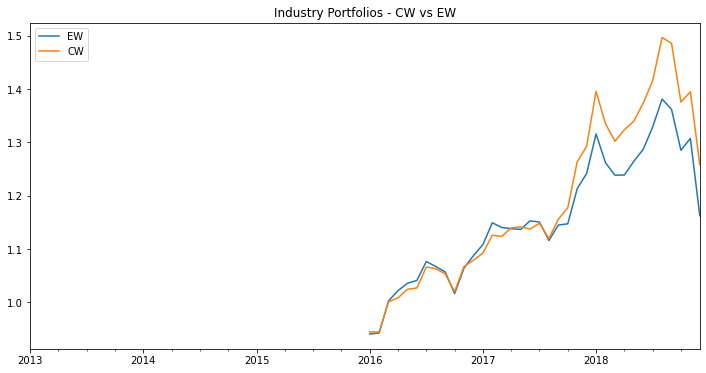

In [63]:
ewr = erk.backtest_ws(fiveind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(fiveind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=fiveind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())